<a href="https://colab.research.google.com/github/vbipin/aip/blob/master/bandits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import scipy.stats

In [0]:
##### Can we do some bandit problems
#K armed bandits Ch5 Sutton Barto

In [0]:
class KArmedBandit :
    def __init__(self, K=10, random_seed=100) :
        self.K = K
        
        #xxx
        np.random.seed(random_seed)
        
        #we select the mean of the arms according to a normal dist
        self.loc = scipy.stats.norm.rvs(loc=0, size=K)

        
    def pull(self, k) : #pull the kth lever
        return scipy.stats.norm.rvs(loc=self.loc[k], size=1)[0]
    
    def pull_all(self) : #pull all the arms once and return the values
        return [ self.pull(i) for i in range(self.K) ]
    
#ban = KArmedBandit()
#ban.pull(0)

In [0]:
def oracle(bandit) :
    """oracle will pull the best arm always"""
    best_arm = np.argmax(bandit.loc)
    return best_arm

In [0]:
######## Experimental. May be wrong 

In [0]:
def greedy_action(bandit, Q) :
    arm = np.argmax(Q)
    return arm

def epsilon_greedy_action(bandit, Q, epsilon) :
    if np.random.random() < epsilon : #we act randomly by choosing one arm randomly
        arm = np.random.randint(0,bandit.K)
    else : #we act greedy; that is we choose the currently best available arm
        arm = greedy_action(bandit, Q)
    return arm

def decay_epsilon_greedy_action(bandit, Q, count, temp) :
    epsilon = 1/count**temp
    if np.random.random() < epsilon : #we act randomly by choosing one arm randomly
        arm = np.random.randint(0,bandit.K)
    else : #we act greedy; that is we choose the currently best available arm
        arm = greedy_action(bandit, Q)
    return arm


def UCB(bandit, Q, count, N, c=2) :
    ext = np.array([ 5 for _ in range(len(N))])
    for i in range(len(N)) :
        if N[i] >0 :
            ext[i] = c * np.sqrt(np.log(count)/N[i])
    
    arm = np.argmax(Q+ext)
    return arm

In [0]:
def learning(bandit, niterations, algorithm, optimistic_init=0) :
    
    N = [ 0 for _ in range(bandit.K) ] #initialize the values to zero
    Q = [ optimistic_init for _ in range(bandit.K) ] #initialize the values to zero
    V = [ 0 for _ in range(bandit.K) ] #initialize the values to zero
    R = []
    A = []
    #now onwards we act greedily
    for c in range(1,niterations+1) :
        arm = algorithm(bandit, Q=Q, t=c, N=N)
        N[arm] += 1
        
        sample = bandit.pull(arm)
        R.append(sample)
        A.append(arm)
        
        V[arm] += sample
        Q[arm] = Q[arm] + (sample - Q[arm])/N[arm]
        
    
    return Q, R, A

In [0]:
algorithms = [
    lambda b, c: learning(b,c, lambda bandit,Q,t,N: oracle(bandit)),
    lambda b, c: learning(b,c, lambda bandit,Q,t,N: UCB(bandit,Q, count=t, N=N)),
    lambda b, c: learning(b,c, lambda bandit,Q,t,N: decay_epsilon_greedy_action(bandit,Q, count=t, temp=0.75)),
    lambda b, c: learning(b,c, lambda bandit,Q,t,N: greedy_action(bandit,Q)),
    #
    lambda b, c: learning(b,c, lambda bandit,Q,t,N: greedy_action(bandit,Q),optimistic_init=5),
    lambda b, c: learning(b,c, lambda bandit,Q,t,N: epsilon_greedy_action(bandit,Q, epsilon=0.1)),
    
    #lambda b, c: learning(b,c, lambda bandit,Q,t,N: epsilon_greedy_action(bandit,Q, epsilon=0.1)),
    #lambda b, c: learning(b,c, lambda bandit,Q,t,N: epsilon_greedy_action(bandit,Q, epsilon=0.1), optimistic_init=5),
    #lambda b, c: learning(b,c, lambda bandit,Q,t,N: epsilon_greedy_action(bandit,Q, epsilon=0.01)),
    #lambda b, c: learning(b,c, lambda bandit,Q,t,N: decay_epsilon_greedy_action(bandit,Q, count=t, temp=0.75)),
]

In [0]:
def average_reward(r) :
    s = 0
    ar = [] #average reward
    for i in range(len(r)) :
        s += r[i]
        ar.append( s/(i+1) )
    return ar
    
def run_experiment_average_reward( algorithms=[], n_trials=1000, count=1000, random_seed=1234 ) :
    exp = [[] for _ in range(len(algorithms)) ]
    for i in range(n_trials) :
        ban = KArmedBandit(random_seed=i+random_seed)
        
        for j, algo in enumerate(algorithms) :
            q,r,a = algo(ban, count)
            ar = average_reward(r)
        
            exp[j].append(ar)
    return [ np.mean(e, axis=0) for e in exp ]

In [0]:
n_trials = 1000
count = 1000
l = run_experiment_average_reward( algorithms, n_trials, count, random_seed=29999)

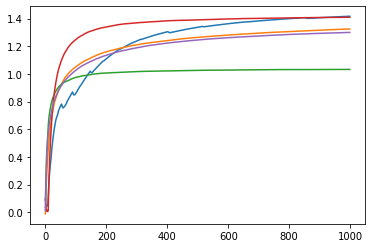

In [26]:
plt.plot(range(count), l[1]) #ucb, blue
plt.plot(range(count), l[2]) #decay epsilon, orange
plt.plot(range(count), l[3]) #greedy, green
plt.plot(range(count), l[4]) #greedy with optimistic init red
plt.plot(range(count), l[5]) #epsilon greedy 0.1 purple
#plt.plot(range(count), l[0])